# COVIDcast Data Smoothing
In this document, we compare different methods of smoothing [COVIDcast signals](https://github.com/cmu-delphi/delphi-epidata/blob/e7cd1012d2046980571a3ded6db6803f64e4506b/docs/api/covidcast_signals.md). See the README.md file for the problem statement and the mathematical background.

The dependencies are listed below. Note that `covidcast` and `delphi_utils` from [this branch](https://github.com/cmu-delphi/covidcast-indicators/tree/dev-smoothing) should be installed in your python environment.

In [1]:
import os
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import covidcast
from delphi_utils import Smoother

## An Example: California Google Health Trends
To begin, let's load a raw example signal, say the [Google Health Trends signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/ght.md) `ght` which records Google search activity.

In [2]:
filename = "ght_raw.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="state", geo_values="ca")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

Let's look at how the smoothers work on this signal.

Recall that `left_gauss_linear` has a dynamic fitting window, but most of the weight is on the most recent 3 weeks. `savgol` has a sharp cutoff at 6 weeks, but the same weighting; it is also fitting a second-degree polynomial to the data.

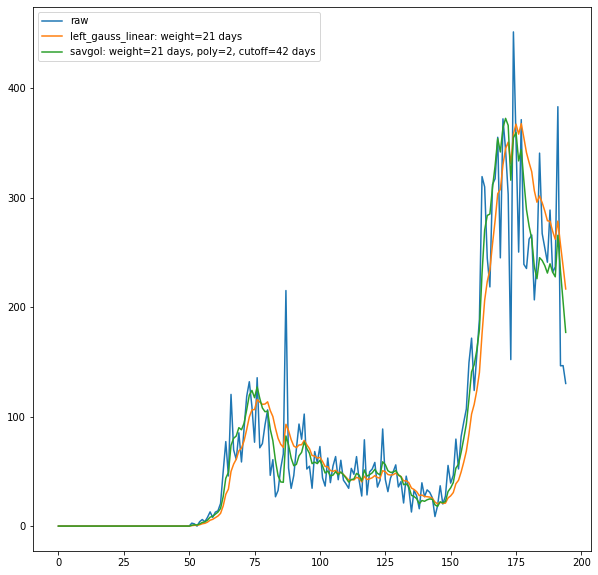

In [58]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother()
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2, cutoff=42 days")
plt.legend()

The unweighted SG filter has large deviations around large peaks.

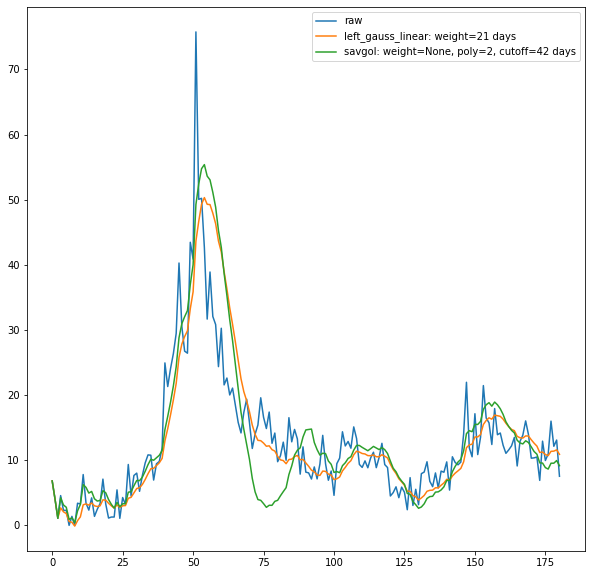

In [9]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother(window_length=42, gaussian_bandwidth=None)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=None, poly=2, cutoff=42 days")
plt.legend()

Bringing the weighting back, but reducing the window cutoff to 28 days and bringing the Gaussian weights to 14 days and 21 days, yields. The two-weeks window seems to do best.

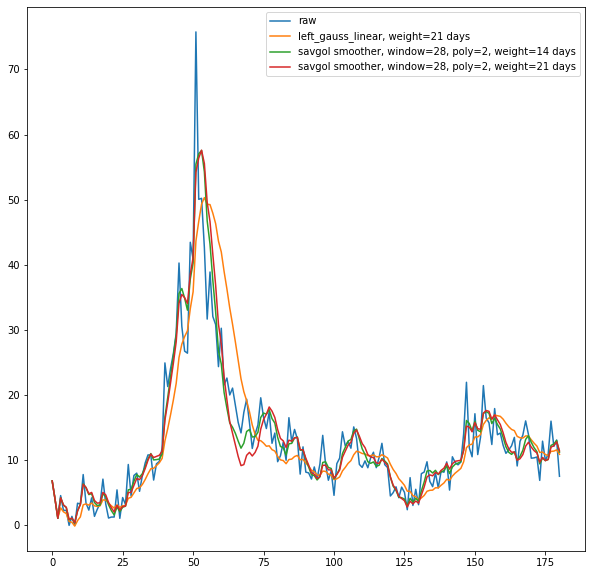

In [10]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear, weight=21 days")
smoother = Smoother(window_length=28, gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=28, poly=2, weight=14 days")
smoother = Smoother(window_length=28, gaussian_bandwidth=325)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=28, poly=2, weight=21 days")
plt.legend()

Increasing the polynomial fit passes through more noise.

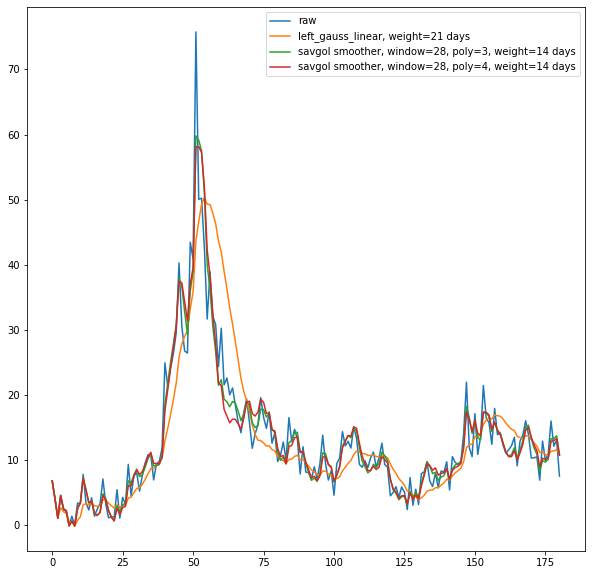

In [13]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear, weight=21 days")
smoother = Smoother(window_length=28, gaussian_bandwidth=144, poly_fit_degree=3)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=28, poly=3, weight=14 days")
smoother = Smoother(window_length=28, gaussian_bandwidth=325, poly_fit_degree=3)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=28, poly=4, weight=14 days")
plt.legend()

Note that `savgol` with polynomial degree 1 is almost identical to `left_gauss_linear`. The difference is that `left_gauss_linear` uses the full past window, but most of those terms are negligible. In a future iteration, we should deprecate the latter.

In [65]:
lgl_smoother = Smoother(method_name='left_gauss_linear')
sg_smoother = Smoother(poly_fit_degree=1)
np.allclose(sg_smoother.smooth(np.array(data_raw.value)), lgl_smoother.smooth(np.array(data_raw.value)), atol=2)

True

## Sparse data
There tends to be less data at the county level and therefore a lot more zeros. We want our smoothers to work well in these situations.

Let's take a look at `ght` again, in the county level region.

In [15]:
filename = "ght_raw_hrr_pittsburgh.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="hrr", geo_values="357")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

`left_gauss_linear` seems to be work fine, `savgol` is more sensitive with its higher degree fit.

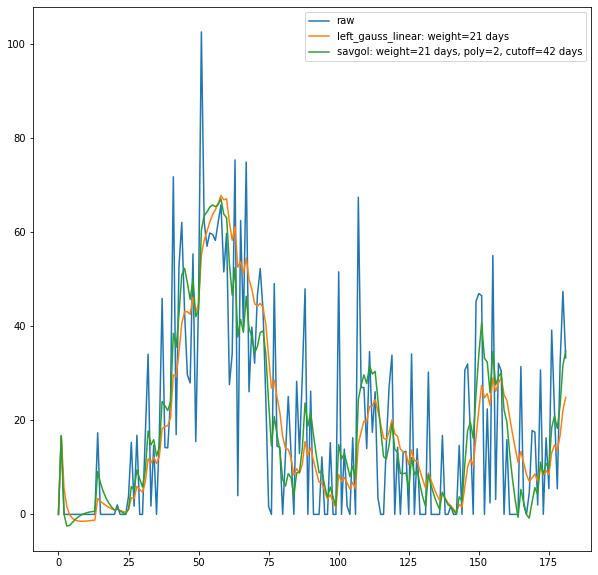

In [23]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother()
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2, cutoff=42 days")
plt.legend()

We can smooth both out with a higher bandwidth. `savgol` is less noisy than before, but I think `left_gauss_linear` looks better.

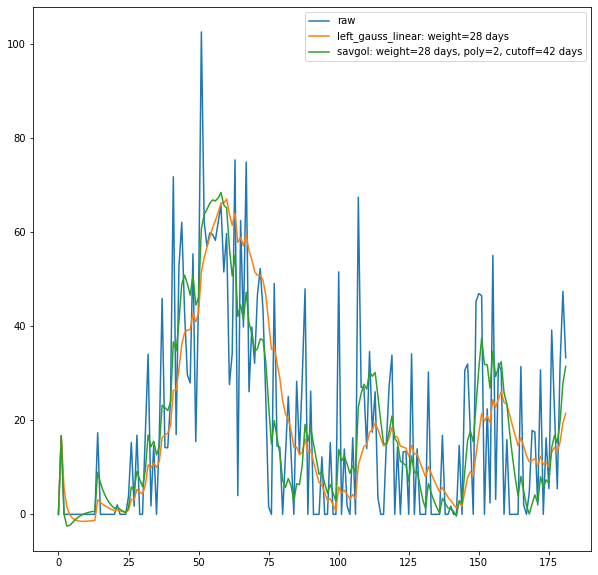

In [31]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=28 days")
smoother = Smoother(gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=28 days, poly=2, cutoff=42 days")
plt.legend()

If we set the `savgol` polynomial to 0, we get something even smoother, but the catch is that the bandwidth has to be lowered. If the bandwidth is too high, the smoother lags behind the data like a moving window average. (Note that setting `savgol` polynomial to 1 yields almost identical results to `left_gauss_linear`).

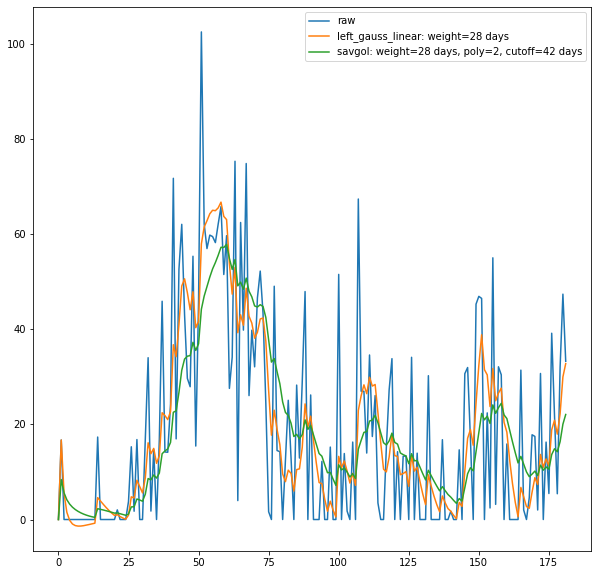

In [34]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
smoother = Smoother(gaussian_bandwidth=100, poly_fit_degree=0)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0, cutoff=42 days")
plt.legend()

Let's look at another hospital region.

In [35]:
filename = "ght_raw_hrr_sacramento.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="hrr", geo_values="77")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

Again, using the polynomial fit degree of zero, we can get something with smaller zigzags. However, the peaks in the data are not represented as well. This may be fine -- if the data peaks simply reflect grouping in reporting, then this is exactly what we want the smoother to disentangle.

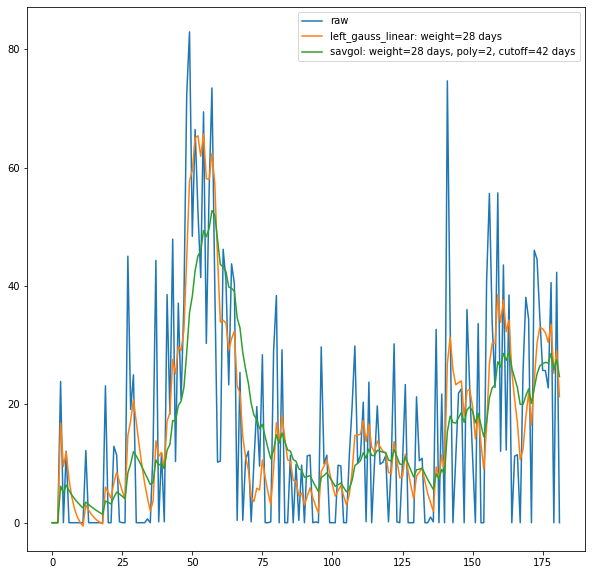

In [36]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
smoother = Smoother(gaussian_bandwidth=100, poly_fit_degree=0)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0, cutoff=42 days")
plt.legend()

Just to test, let's try polynomial degree 2 again. Very noise sensitive. Improved a little by increasing the bandwidth.

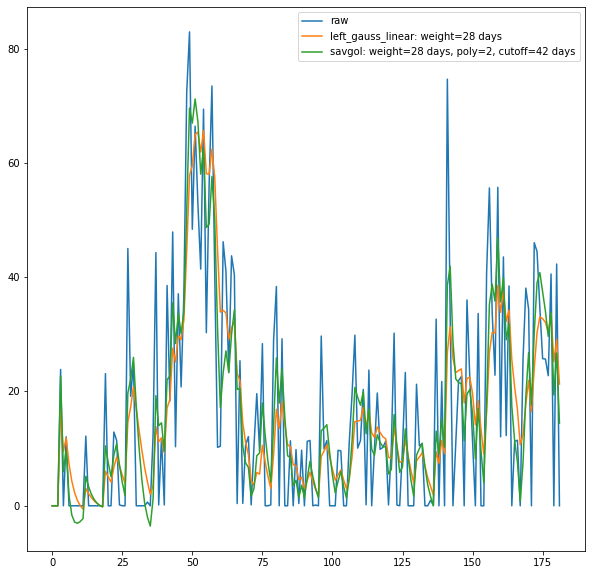

In [37]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
smoother = Smoother(gaussian_bandwidth=100, poly_fit_degree=2)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=2, cutoff=42 days")
plt.legend()

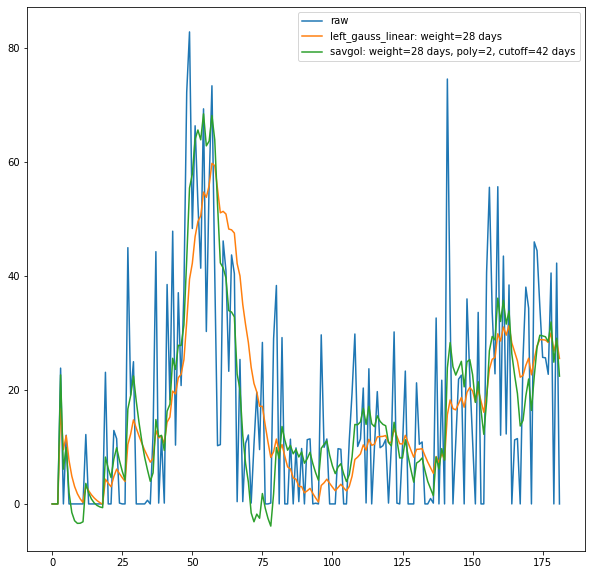

In [39]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=28 days")
smoother = Smoother(gaussian_bandwidth=600, poly_fit_degree=2)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=28 days, poly=2, cutoff=42 days")
plt.legend()

Let's take a look at a different indicator, `jhu-csse`.

In [48]:
filename = "jhu_confirmed_incidence_hrr_sacramento.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal(data_source="jhu-csse", 
                                signal="confirmed_incidence_num", 
                                start_day=None, 
                                end_day=None, 
                                geo_type="hrr", 
                                geo_values="77")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

The same pattern is showing up: `savgol` is slightly more sensitive to noise.

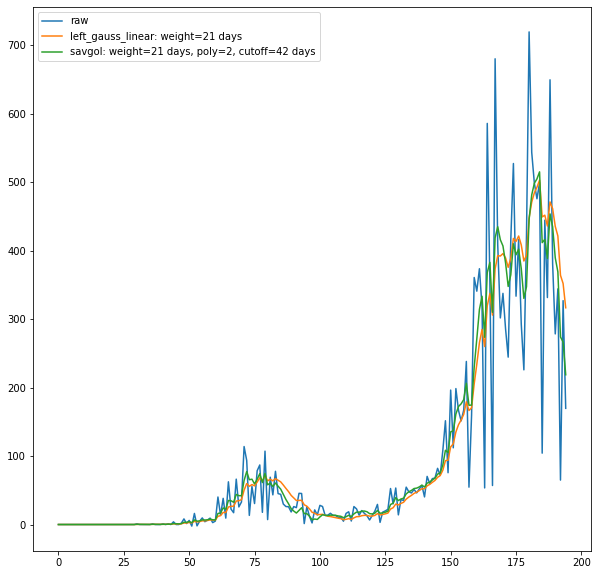

In [49]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother()
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2, cutoff=42 days")
plt.legend()

We can tame the noise by changing polynomial degree to 0.

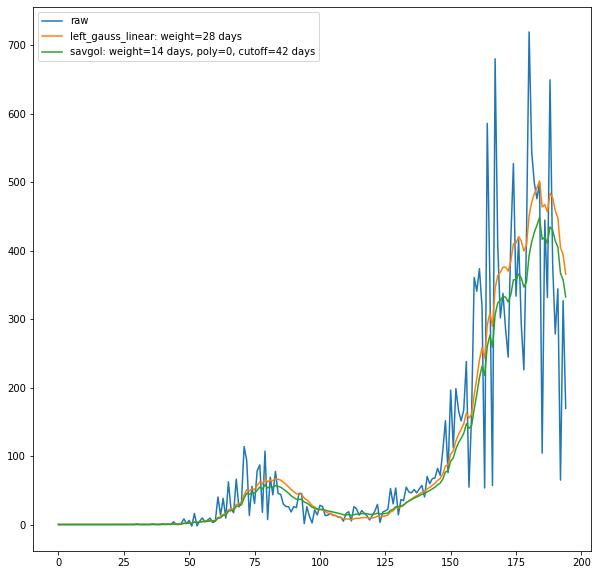

In [52]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=28 days")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0, cutoff=42 days")
plt.legend()

In [53]:
filename = "jhu_confirmed_incidence_hrr_pittsburgh.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal(data_source="jhu-csse", 
                                signal="confirmed_incidence_num", 
                                start_day=None, 
                                end_day=None, 
                                geo_type="hrr", 
                                geo_values="357")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

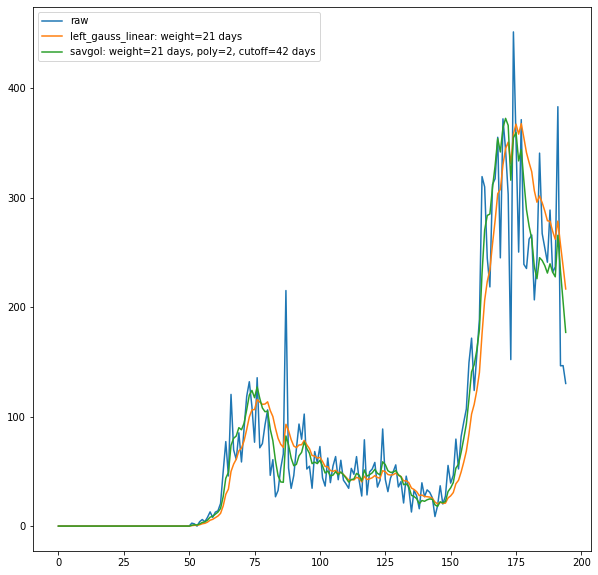

In [54]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother()
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2, cutoff=42 days")
plt.legend()

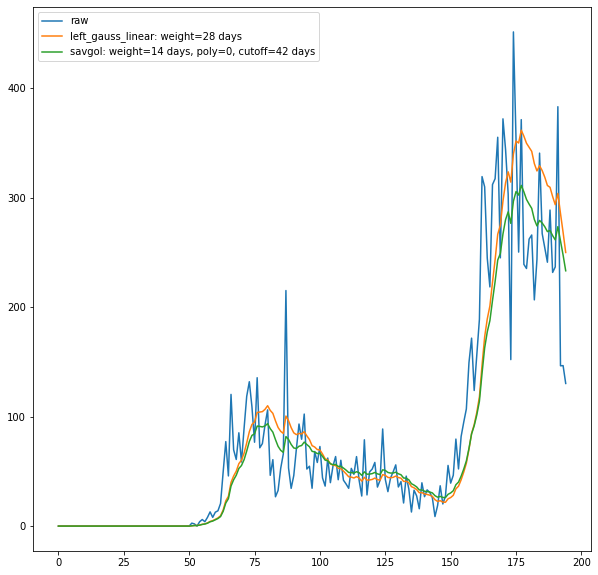

In [56]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=28 days")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0, cutoff=42 days")
plt.legend()

## Simulated zero-censored data
Suppose we randomly censor some small data points by setting them to zero. How well do the smoothers perform?

Here we see that the SG method can dip into the negatives, which is not great, but can be fixed by zero-thresholding. SG is also more sensitive to noise, so a larger window (4 weeks) helps. Reducing the degree down to 2 makes the method less noise-sensitive. However, the height of the peak isn't as well captured. 

Perhaps instead of zero-censoring, we can instead keep the last non-threshold value to reduce the size of the dips?

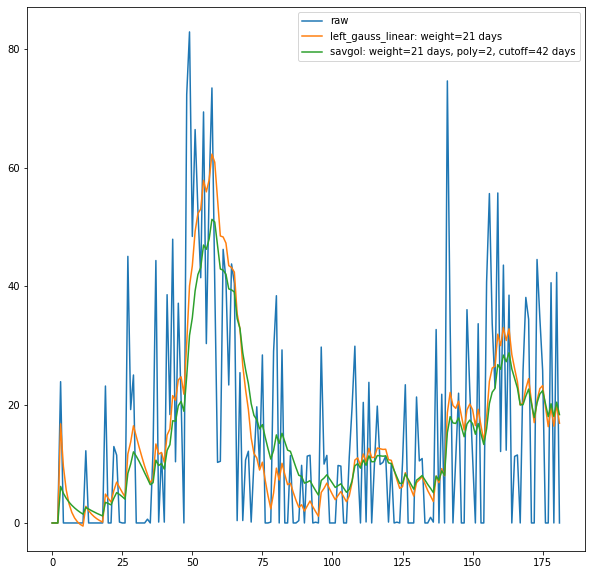

In [44]:
def censor_data(x, n):
    """
    Randomly zero out n values from the array.
    """
    for i in range(n):
        ix = np.random.randint(len(x))
        x[ix] = 0
    return x

data_censored = censor_data(np.array(data_raw.value), 10)
plt.figure(figsize=(10,10))
plt.plot(data_censored, label="raw")
smoother = Smoother('left_gauss_linear')
plt.plot(smoother.smooth(data_censored), label="left_gauss_linear: weight=21 days")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=100)
plt.plot(smoother.smooth(data_censored), label="savgol: weight=21 days, poly=2, cutoff=42 days")
plt.legend()

In [45]:
## Other Signals
Many of the other signals had obstacles to a clear comparison.

- The `doctor-visits` and `hospital-admissions` [signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/doctor-visits.md) are already smoothed by the provider. The raw data does not appear to be available.
- The `fb-survey` and `google-survey` signal require access to the survey data. 

SyntaxError: invalid syntax (<ipython-input-45-81fa9401cce0>, line 2)